#### Multilayer_perceptron in tensorflow

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True, reshape=False)

import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm
import pandas as pd

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./t10k-labels-idx1-ubyte.gz


In [2]:
## clear default graph 
tf.reset_default_graph()

#### 1. set up hyper premeter 
- with dropout option

In [3]:
save_file = './train_model.ckpt'    ## give a name for saving the model 

learning_rate = 0.001
training_epochs = 40
batch_size = 128               # Decrease batch size if you don't have enough memory
display_step = 1

n_input = 784                  # MNIST data input (img shape: 28*28)
n_classes = 10                 # MNIST total classes (0-9 digits)

n_hidden_layer = 256           # layer number of features

# use dropout
keep_rate = 0.5                ## if keep prob == 1 then, there is no dropout

#### 2.  Store layers weight & bias

In [4]:
weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input,n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer,n_classes]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

#### 3. Build Graph 
- with dropout

In [5]:
## keep probability for drop out
keep_prob = tf.placeholder(tf.float32)

## input layer 
x = tf.placeholder("float",[None,28,28,1])      ## because out data is in grey scale, so only has 1 channel 
y = tf.placeholder("float",[None,n_classes])
x_flat = tf.reshape(x,[-1,n_input])             ## this will reshape a 28 X 28 matrix into a row vector

## hidden layer 
layer_1 = tf.add(tf.matmul(x_flat,weights['hidden_layer']),biases['hidden_layer'])
layer_1 = tf.nn.relu(layer_1)
layer_1 = tf.nn.dropout(layer_1,keep_prob)      ## apply dropout 

## output layer with linear ativateion 
logits = tf.add(tf.matmul(layer_1,weights['out']),biases['out'])    ## output layer is a linear operation

#### 4. Optimizer 

In [6]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

#### 5. calculate acuracy

In [7]:
correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#### 6. Run in session and save the model 

In [8]:
init = tf.global_variables_initializer()     ## initializer 
saver = tf.train.Saver()
train_acc_list = []
valid_acc_list = []
loss_list = []

with tf.Session() as sess:
    sess.run(init)                           ## run initializer
    ## train cycles 
    epoch = None
    valid_accuracy = None
    #epoch_pbar = tqdm(range(training_epochs), desc='Epoch: {}, Validation Accuracy: {}'.format(epoch, valid_accuracy), unit='epoches')
    for epoch in range(training_epochs):   ## use tqdm for process bar 
        total_batch = math.ceil(mnist.train.num_examples/batch_size)
        ## loop over all batches 
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _,loss = sess.run([optimizer,cost], feed_dict={x: batch_x, y: batch_y,keep_prob: keep_rate})
    
        # Calculate Training and Validation accuracy
        training_accuracy = sess.run(accuracy,feed_dict={
                    x: mnist.train.images,
                    y: mnist.train.labels,
                    keep_prob: 1.0})
        validation_accuracy = sess.run(accuracy, feed_dict={
                    x: mnist.train.images,
                    y: mnist.train.labels,
                    keep_prob: 1.0})
        # Log accuracy
        loss_list.append(loss)
        train_acc_list.append(training_accuracy)
        valid_acc_list.append(validation_accuracy)
                               
        ## print status for every 10 epochs 
        if epoch % 10 == 0:
            print('Epoch {:<3} - Validation Accuracy: {}'.format(
                epoch,
                validation_accuracy))
            
    ####################################
    ## save the model for future use####
    ####################################
    saver.save(sess, save_file)
    print('Trained Model Saved.')

Epoch 0   - Validation Accuracy: 0.3877090811729431
Epoch 10  - Validation Accuracy: 0.8102545738220215
Epoch 20  - Validation Accuracy: 0.847672700881958
Epoch 30  - Validation Accuracy: 0.8632000088691711
Trained Model Saved.


#### 7.Visualize loss and accuracy 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


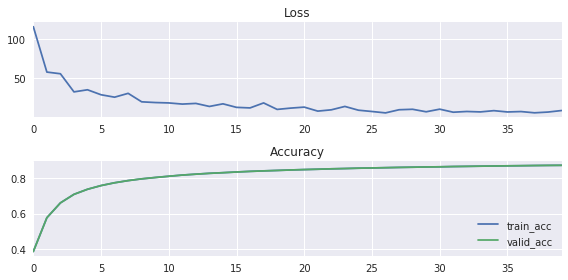

In [9]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

df = pd.DataFrame(list(zip(loss_list,train_acc_list,valid_acc_list)),columns=['loss','train_acc','valid_acc'])

figsize=(8, 4)
fig = plt.figure(figsize=figsize)
layout = (2, 1)
loss_chart   = plt.subplot2grid(layout, (0, 0))
accuracy_chart = plt.subplot2grid(layout, (1, 0))
loss_chart.set_title('Loss')
accuracy_chart.set_title('Accuracy')
df['loss'].plot(ax = loss_chart)
df[['train_acc','valid_acc']].plot(ax=accuracy_chart)
plt.tight_layout()
plt.show()

#### 8. Load the model back and do prediction 

In [10]:
save_file = './train_model.ckpt'
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)

    test_accuracy = sess.run(
        accuracy,
        feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.8777999877929688
